In [1]:
cd ~/sodetlib/scripts

/home/msilvafe/sodetlib/scripts


In [20]:
import resonator_model 
import resonator_fitting as res
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.ion()

In [3]:
tunefile = '/home/msilvafe/Documents/1609650548_tune.npy'

In [4]:
data=np.load(tunefile,allow_pickle=True).item()
fdata = np.asarray([data[2]['resonances'][idx]['freq'] for idx in data[2]['resonances'].keys()])

In [25]:
def one_resonator_fitting(tunefile): 
    dres = {'time':[],'resonator_index':[], 'f0':[], 'Qi':[],
            'Qc':[],'Q':[],'br': [],'depth':[],'Q_e_imag':[],
            'delay':[],'phi':[],'f_min':[],'A_mag':[],
            'A_slope':[]}
    dfres =pd.DataFrame(dres)
    data=np.load(tunefile,allow_pickle=True).item()
    for band in list(data.keys()):
        if 'resonances' in list(data[band].keys()):
            for idx in list(data[band]['resonances'].keys()):
                scan=data[band]['resonances'][idx]
                f=scan['freq_eta_scan']
                s21=scan['resp_eta_scan']
                result=res.full_fit(f,s21.real,s21.imag)

                f0 = result.best_values['f_0']
                Q = result.best_values['Q']
                Qc = result.best_values['Q_e_real']
                Q_e_imag = result.best_values['Q_e_imag']
                delay = result.best_values['delay']
                phi = result.best_values['phi']
                f_min = result.best_values['f_min']
                A_mag = result.best_values['A_mag']
                A_slope = result.best_values['A_slope']
                Qi = res.get_qi(result.best_values['Q'], result.best_values['Q_e_real'])
                br = res.get_br(result.best_values['Q'], result.best_values['f_0'])
                res_index = scan['channel']+band*512
                time=data[band]['find_freq']['timestamp'][0]
                s21_mag=np.abs(result.best_fit.real+1j*result.best_fit.imag)
                depth = max(s21_mag)-min(s21_mag)
                dfres = dfres.append({'time':time,
                                      'resonator_index': int(res_index), 
                                      'f0': f0, 'Qi': Qi, 'Qc': Qc, 
                                      'Q': Q, 'br':br,'depth':depth,
                                     'Q_e_imag': Q_e_imag,'delay': delay,
                                     'phi':phi,'f_min':f_min,'A_mag':A_mag,
                                     'A_slope':A_slope}, ignore_index=True)
    return dfres

In [26]:
dfres = one_resonator_fitting(tunefile)

In [27]:
dfres.columns

Index(['time', 'resonator_index', 'f0', 'Qi', 'Qc', 'Q', 'br', 'depth',
       'Q_e_imag', 'delay', 'phi', 'f_min', 'A_mag', 'A_slope'],
      dtype='object')

In [272]:
meas_idx = 0
fmeas = [5114.4939,5183.0828,5154.2519,5099.2008]
Pmeas = [-38.66,-35.4,-36.44,-38.7]
dBcmeas = [-101.6,-101.1,-101.9,-102.7]
dBc_expected = -123.94 - np.asarray(Pmeas)
f_ref = fmeas[meas_idx]
pd_idxmin = np.argmin(np.abs(dfres['f0']-f_ref))
data_idxmin = np.argmin(np.abs(fdata-f_ref))
print(dfres['f0'][pd_idxmin],fdata[data_idxmin])

5114.879925661365 5114.889994630814


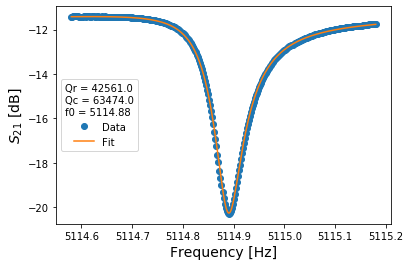

In [273]:
plt.plot(data[2]['resonances'][data_idxmin]['freq_eta_scan'],
        20*np.log10(np.abs(data[2]['resonances'][data_idxmin]['resp_eta_scan'])),
         'o',label = 'Data')
fplot = np.linspace(np.min(data[2]['resonances'][data_idxmin]['freq_eta_scan']),
                   np.max(data[2]['resonances'][data_idxmin]['freq_eta_scan']),
                    500)
params = {'f_0' : dfres['f0'][pd_idxmin],
          'Q' : dfres['Q'][pd_idxmin],
          'Q_e_real': dfres['Qc'][pd_idxmin],
          'Q_e_imag' : dfres['Q_e_imag'][pd_idxmin],
          'delay' : dfres['delay'][pd_idxmin],
          'phi' : dfres['phi'][pd_idxmin],
          'f_min' : dfres['f_min'][pd_idxmin],
          'A_mag' : dfres['A_mag'][pd_idxmin],
         'A_slope' : dfres['A_slope'][pd_idxmin]}

S21_plot = resonator_model.resonator_cable(fplot,**params)
plt.plot(fplot,20*np.log10(np.abs(S21_plot)),label = 'Fit')

plt.xlabel('Frequency [Hz]',fontsize = 14)
plt.ylabel('$S_{21}$ [dB]',fontsize = 14)
plt.legend(loc = 'center left',
           title = f'Qr = {np.round(dfres["Q"][pd_idxmin],0)}\nQc = {np.round(dfres["Qc"][pd_idxmin],0)}\nf0 = {np.round(dfres["f0"][pd_idxmin],2)}')

In [306]:
def dfduPhi0_to_dfdI(dfduphi0,M_in):
    M_in_phi0_per_A = M_in/2.067833848e-15 #Phi0/A = [Wb/A]/[Wb/Phi0]
    dfdphi0 = dfduphi0*1e6 #Hz/phi0 = [Hz/uphi0]*[uphi0/phi0]
    dfdI_Hz_per_A = dfdphi0*M_in_phi0_per_A #Hz/A = [HZ/Phi0]*[Phi0/A]
    dfdI_Hz_per_pA = dfdI_Hz_per_A*1e-12 #Hz/pA = [Hz/A]*[A/pA]
    return dfdI_Hz_per_pA

def find_dBc_given_NEI_Vq(NEI,dfdI,Qr,f0,Qc):
    return 20*np.log10(NEI*dfdI*np.sqrt(2)*(2*Qr**2)/(f0*1e6*Qc))

def find_dBc_given_NEI_phi(NEI,dfdI,Qr,f0,Qc):
    return 20*np.log10(NEI*dfdI*np.sqrt(2)*(2*Qr**2)/(f0*(Qc-Qr)*1e6))

#def find_NEI_give_dBc_Vq(dBc,dfdI,Qr,f0,Qc):
#    return 10**((dBc)/20)*(f0*1e6*Qc)/(2*Qr**2)/np.sqrt(2)/dfdI

def find_NEI_give_dBc_Vq(dBc,dfdI,Qr,f0,Qc):
    return 10**((dBc)/20)*(f0*1e6)/(2*Qr)/dfdI

def find_NEI_give_dBc_phi(dBc,dfdI,Qr,f0,Qc):
    return 10**((dBc)/20)*(f0*(Qc-Qr)*1e6)/(2*Qr**2)/dfdI

In [307]:
dfdphi = [0.136,0.112,0.165,0.124]
NEIs = [107.51,48.71,262.77,89.53]
NEImeas3 = [78.66,39.08,219.16,66.96]
NEImeas6 = [63.63,33.34,163.03,50.05]
dfdI = dfduPhi0_to_dfdI(dfdphi[meas_idx],227e-12)
print(f'dfdI: {dfdI}')
Qr = dfres['Q'][pd_idxmin]
Qc = dfres['Qc'][pd_idxmin]
f0 = dfres['f0'][pd_idxmin]
dBcVq = find_dBc_given_NEI_Vq(NEIs[meas_idx],dfdI,Qr,f0,Qc)
dBcphi = find_dBc_given_NEI_phi(NEIs[meas_idx],dfdI,Qr,f0,Qc)
print('Expected dBc:', dBc_expected[meas_idx],
      '\nDerived dBc:',dBcVq,dBcphi)
print(NEIs[meas_idx])
NEI3q = find_NEI_give_dBc_Vq(dBcVq-3,dfdI,Qr,f0,Qc)
NEI3phi = find_NEI_give_dBc_phi(dBcphi-3,dfdI,Qr,f0,Qc)
print('Measured NEI3:',NEImeas3[meas_idx],
      '\nDerived NEI3:',NEI3q,NEI3phi)
NEI6q = find_NEI_give_dBc_Vq(dBcVq-6,dfdI,Qr,f0,Qc)
NEI6phi = find_NEI_give_dBc_phi(dBcphi-6,dfdI,Qr,f0,Qc)
print('Measured NEI6:',NEImeas6[meas_idx],
      '\nDerived NEI6:',NEI6q,NEI6phi)

dfdI: 0.014929632779664219
Expected dBc: -85.28 
Derived dBc: -91.92728360195281 -82.2836453401581
107.51
Measured NEI3: 78.66 
Derived NEI3: 72.17403511471132 107.63756380814439
Measured NEI6: 63.63 
Derived NEI6: 51.09530390145268 76.20155953935456


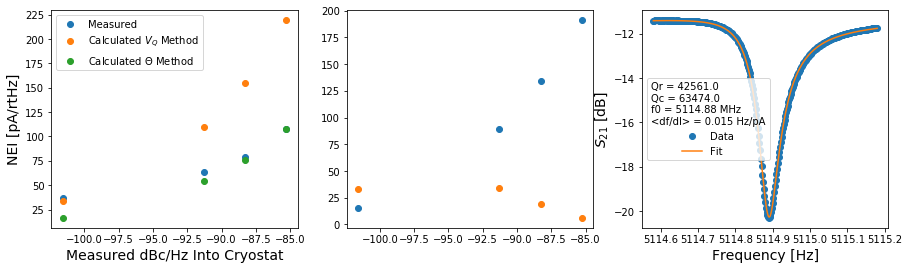

In [308]:
dBc_plot = [dBc_expected[meas_idx],dBc_expected[meas_idx]-3,dBc_expected[meas_idx]-6,dBcmeas[meas_idx]]
NEI_off = [36.74,25.23,28.23,31.35]
NEI_plot = [NEIs[meas_idx],NEImeas3[meas_idx],NEImeas6[meas_idx],NEI_off[meas_idx]]

plt.figure(figsize = (15,4))
plt.subplot(1,3,1)
plt.plot(dBc_plot,NEI_plot,'o',label = 'Measured')
plt.plot(dBc_plot,find_NEI_give_dBc_Vq(np.asarray(dBc_plot),dfdI,Qr,f0,Qc),'o',label = 'Calculated $V_Q$ Method')
plt.plot(dBc_plot,find_NEI_give_dBc_phi(np.asarray(dBc_plot),dfdI,Qr,f0,Qc),'o',label = 'Calculated $\Theta$ Method')
plt.xlabel('Measured dBc/Hz Into Cryostat',fontsize = 14)
plt.ylabel('NEI [pA/rtHz]',fontsize = 14)
plt.legend(loc = 'upper left')
plt.subplot(1,3,2)
plt.plot(dBc_plot,np.sqrt(np.abs(find_NEI_give_dBc_Vq(np.asarray(dBc_plot),dfdI,Qr,f0,Qc)**2-np.asarray(NEI_plot)**2)),'o')
plt.plot(dBc_plot,np.sqrt(np.abs(find_NEI_give_dBc_phi(np.asarray(dBc_plot),dfdI,Qr,f0,Qc)**2-np.asarray(NEI_plot)**2)),'o')

plt.subplot(1,3,3)
plt.plot(data[2]['resonances'][data_idxmin]['freq_eta_scan'],
        20*np.log10(np.abs(data[2]['resonances'][data_idxmin]['resp_eta_scan'])),
         'o',label = 'Data')
plt.plot(fplot,20*np.log10(np.abs(S21_plot)),label = 'Fit')
plt.xlabel('Frequency [Hz]',fontsize = 14)
plt.ylabel('$S_{21}$ [dB]',fontsize = 14)
plt.legend(loc = 'center left',
           title = f'Qr = {np.round(dfres["Q"][pd_idxmin],0)}\nQc = {np.round(dfres["Qc"][pd_idxmin],0)}\nf0 = {np.round(dfres["f0"][pd_idxmin],2)} MHz\n<df/dI> = {np.round(dfdI,3)} Hz/pA')


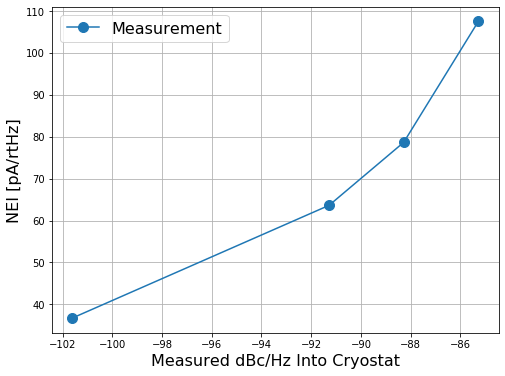

In [318]:
plt.figure(figsize = (8,6))
plt.plot(dBc_plot,NEI_plot,'o-',markersize = 10,label = 'Measurement')
#plt.plot(dBc_plot,find_NEI_give_dBc_Vq(np.asarray(dBc_plot),dfdI,Qr,f0,Qc),'o',label = 'Initial Method')
#plt.plot(dBc_plot,find_NEI_give_dBc_phi(np.asarray(dBc_plot),dfdI,Qr,f0,Qc),'o',label = 'Calculated $\Theta$ Method')
plt.xlabel('Measured dBc/Hz Into Cryostat',fontsize = 16)
plt.ylabel('NEI [pA/rtHz]',fontsize = 16)
plt.legend(loc = 'upper left',fontsize = 16)
plt.grid()